#### Pre-processing

In [84]:
### TODO: DELETE THIS NOTEBOOK BEFORE SUBMISSION
### IT USES PANDAS WHICH WE'RE NOT ALLOWED TO RELY ON AFTER SUBMISSION

import json

import pandas as pd

# load JSON logs
with open("logs/pretraining.json") as f:
    data = json.load(f)

# flatten into list of rows
rows = []
for run_name, epochs in data.items():
    for epoch_str, metrics in epochs.items():
        epoch = int(epoch_str)
        row = {"run_name": run_name, "epoch": epoch}
        row.update(metrics)
        rows.append(row)

df = pd.DataFrame(rows)
df

,run_name,epoch,train_loss,train_ClassifierHead(2)_loss,train_ClassifierHead(2)_Acc,val_loss,val_ClassifierHead(2)_loss,val_ClassifierHead(2)_Acc,train_ClassifierHead(37)_loss,train_ClassifierHead(37)_Acc,val_ClassifierHead(37)_loss,val_ClassifierHead(37)_Acc,train_BboxHead_loss,train_BboxHead_IoU,val_BboxHead_loss,val_BboxHead_IoU
0,cnn_species,1,0.610392,0.610392,0.670791,0.591884,0.591884,0.689531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cnn_species,2,0.589961,0.589961,0.698434,0.586430,0.586430,0.708484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cnn_species,3,0.582057,0.582057,0.706940,0.579895,0.579895,0.705776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cnn_species,4,0.577658,0.577658,0.713319,0.577766,0.577766,0.703069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,cnn_species,5,0.571973,0.571973,0.722405,0.578491,0.578491,0.711191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,res_species_breed_bbox_101,16,2.980323,0.313315,1.000000,3.104190,0.314442,0.999097,2.663171,0.974870,2.706618,0.909747,0.003837,0.811542,0.083129,0.365937
556,res_species_breed_bbox_101,17,2.984249,0.313484,1.000000,3.124078,0.315154,0.998195,2.666342,0.956505,2.725172,0.871841,0.004424,0.801490,0.083752,0.412779
557,res_species_breed_bbox_101,18,3.005216,0.315859,0.997487,3.151510,0.323407,0.988267,2.678745,0.937174,2.742979,0.825812,0.010612,0.728161,0.085124,0.334706
558,res_species_breed_bbox_101,19,3.018622,0.316467,0.997100,3.140236,0.317496,0.994585,2.683418,0.930988,2.738145,0.852888,0.018737,0.661039,0.084594,0.345992


In [87]:
import re


### extract architecture and task
def extract_arch_task(name):
    # try matching optional prefix and suffix
    m = re.match(r"^([a-z]+)(?:_)?([a-z]+(?:_[a-z]+)*?)(?:_(\d+|[a-z]+))?$", name)
    if not m:
        return None, None
    prefix, mid, suffix = m.groups()
    if suffix and (suffix.isdigit()):
        arch = f"{prefix}{suffix}"
        task = mid
    else:
        arch = prefix
        task = mid + (f"_{suffix}" if suffix else "")
    return arch, task


df[["arch", "task"]] = df["run_name"].apply(
    lambda name: pd.Series(extract_arch_task(name))
)

### replace inconsistent names with consistent ones
task_replacements = {"breed_species": "species_breed"}
df["task"] = df["task"].replace(task_replacements)

df[["run_name", "arch", "task"]]

,run_name,arch,task
0,cnn_species,cnn,species
1,cnn_species,cnn,species
2,cnn_species,cnn,species
3,cnn_species,cnn,species
4,cnn_species,cnn,species
...,...,...,...
555,res_species_breed_bbox_101,res101,species_breed_bbox
556,res_species_breed_bbox_101,res101,species_breed_bbox
557,res_species_breed_bbox_101,res101,species_breed_bbox
558,res_species_breed_bbox_101,res101,species_breed_bbox


#### Analysis

In [92]:
import matplotlib.pyplot as plt
import pandas as pd


def best_epochs_by_metric(df: pd.DataFrame, target_metric: str) -> pd.DataFrame:
    return (
        df.loc[df.groupby("run_name")[target_metric].idxmin()]
        .reset_index(drop=True)
        .sort_values(target_metric, ascending=False)
    )


def filter_epochs(df: pd.DataFrame) -> pd.DataFrame:
    return df[((df["epoch"]) % 5 == 0)]


def visualize_task_performance(
    best_epochs_df: pd.DataFrame, task_name: str, eval_metrics: list[str]
):
    # filter for matching task_name
    df = best_epochs_df[best_epochs_df["task"] == task_name]

    if df.empty:
        print(f"no runs found for task '{task_name}'")
        return

    # set up bar chart
    x_labels = df["arch"].astype(str)
    x = range(len(x_labels))
    width = 0.8 / len(eval_metrics)  # divide bar width over metrics

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, metric in enumerate(eval_metrics):
        if metric not in df.columns:
            print(f"warning: metric '{metric}' not in dataframe")
            continue
        offsets = [xi + i * width for xi in x]
        ax.bar(offsets, df[metric], width=width, label=metric)

    ax.set_xticks([xi + width * (len(eval_metrics) - 1) / 2 for xi in x])
    ax.set_xticklabels(x_labels, rotation=45, ha="right")
    ax.set_ylabel("metric value")
    ax.set_title(f"Task performance for '{task_name}'")
    ax.legend()
    ax.grid(True, axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

In [94]:
print("Showing best checkpoint per run:")
best_epochs_by_metric(filter_epochs(df), "val_loss")

Showing best checkpoint per run:


,run_name,epoch,train_loss,train_ClassifierHead(2)_loss,train_ClassifierHead(2)_Acc,val_loss,val_ClassifierHead(2)_loss,val_ClassifierHead(2)_Acc,train_ClassifierHead(37)_loss,train_ClassifierHead(37)_Acc,val_ClassifierHead(37)_loss,val_ClassifierHead(37)_Acc,train_BboxHead_loss,train_BboxHead_IoU,val_BboxHead_loss,val_BboxHead_IoU,arch,task
6,cnn_species_breed_bbox,15,3.843169,0.526768,0.777692,3.923500,0.570302,0.733755,3.243255,0.265223,3.280108,0.205776,0.073145,0.162803,0.073090,0.170850,cnn,species_breed_bbox
3,cnn_breed_species,20,3.657440,0.484520,0.826020,3.851545,0.597261,0.699458,3.172919,0.324377,3.254284,0.231949,NaN,NaN,NaN,NaN,cnn,breed_species
2,cnn_breed_bbox,20,3.241910,NaN,NaN,3.318690,NaN,NaN,3.169260,0.320124,3.245836,0.209386,0.072651,0.166145,0.072854,0.150424,cnn,breed_bbox
1,cnn_breed,20,3.169412,NaN,NaN,3.238008,NaN,NaN,3.169412,0.306399,3.238008,0.237365,NaN,NaN,NaN,NaN,cnn,breed
26,res_species_breed_bbox_18,15,2.973856,0.313433,1.000000,3.152782,0.317338,0.997292,2.657479,1.000000,2.756723,0.918773,0.002943,0.834217,0.078721,0.291385,res18,species_breed_bbox
27,res_species_breed_bbox_50,15,2.984973,0.313414,1.000000,3.111795,0.315469,0.997292,2.666222,0.935821,2.711680,0.875451,0.005338,0.784153,0.084646,0.358452,res50,species_breed_bbox
25,res_species_breed_bbox_101,15,2.981458,0.313320,1.000000,3.098462,0.314653,0.998195,2.663282,0.972550,2.705084,0.914260,0.004856,0.797551,0.078726,0.311420,res101,species_breed_bbox
17,res_breed_species_18,20,2.970070,0.313318,1.000000,3.063818,0.318815,0.994585,2.656752,1.000000,2.745003,0.923285,NaN,NaN,NaN,NaN,res18,breed_species
18,res_breed_species_50,20,2.978712,0.313415,0.999807,3.037014,0.315977,0.997292,2.665297,0.970230,2.721036,0.896209,NaN,NaN,NaN,NaN,res50,breed_species
16,res_breed_species_101,5,2.998977,0.314408,0.999420,3.022974,0.315339,0.998195,2.684569,0.899865,2.707634,0.865523,NaN,NaN,NaN,NaN,res101,breed_species


Printing best-epoch-performance per run per task:


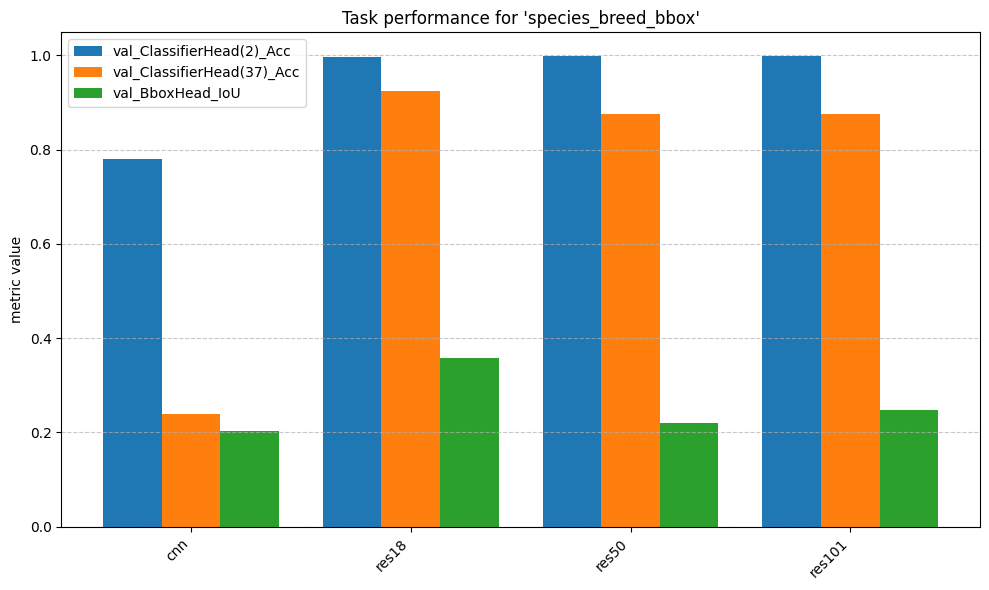

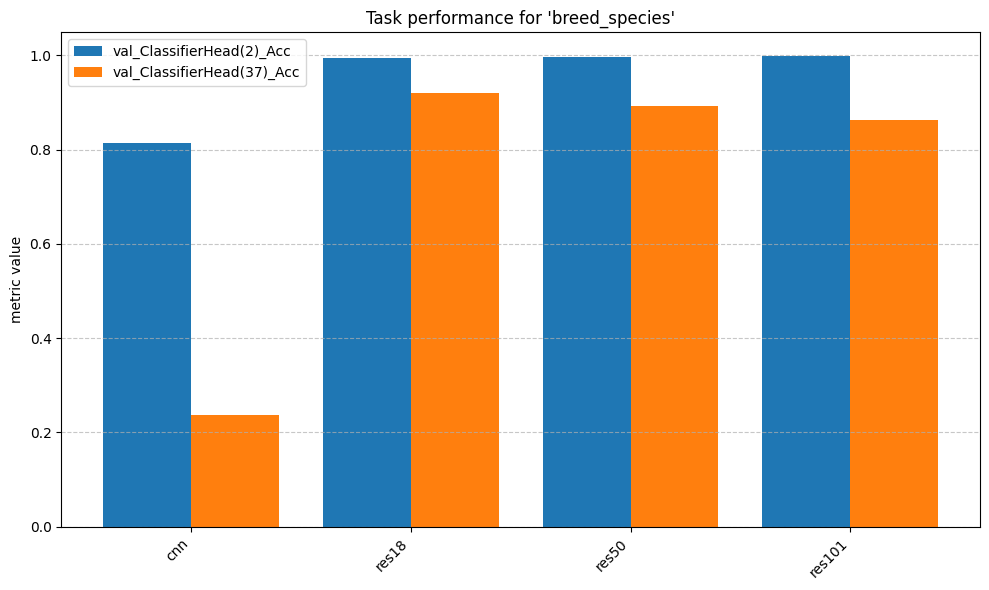

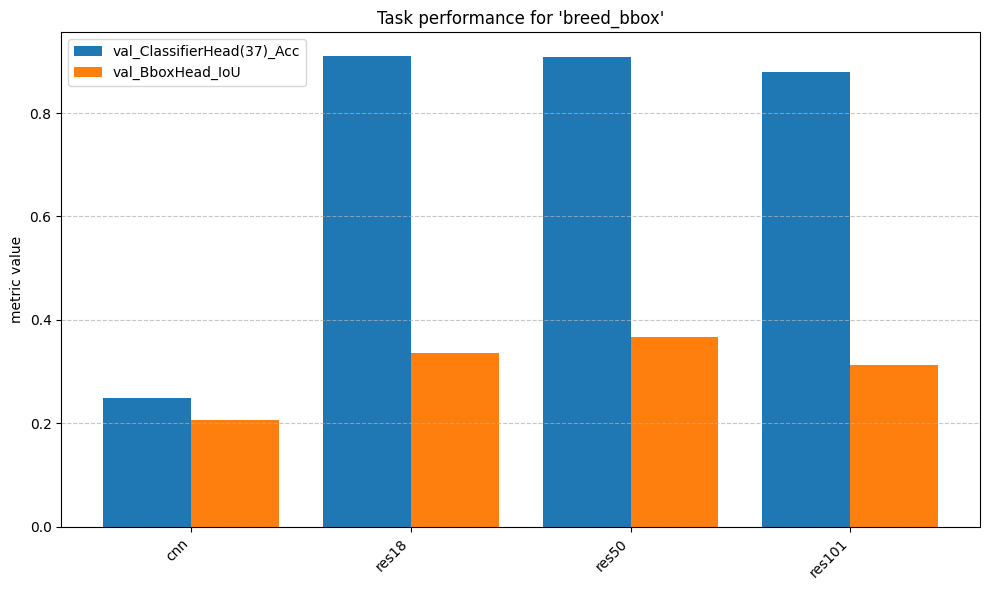

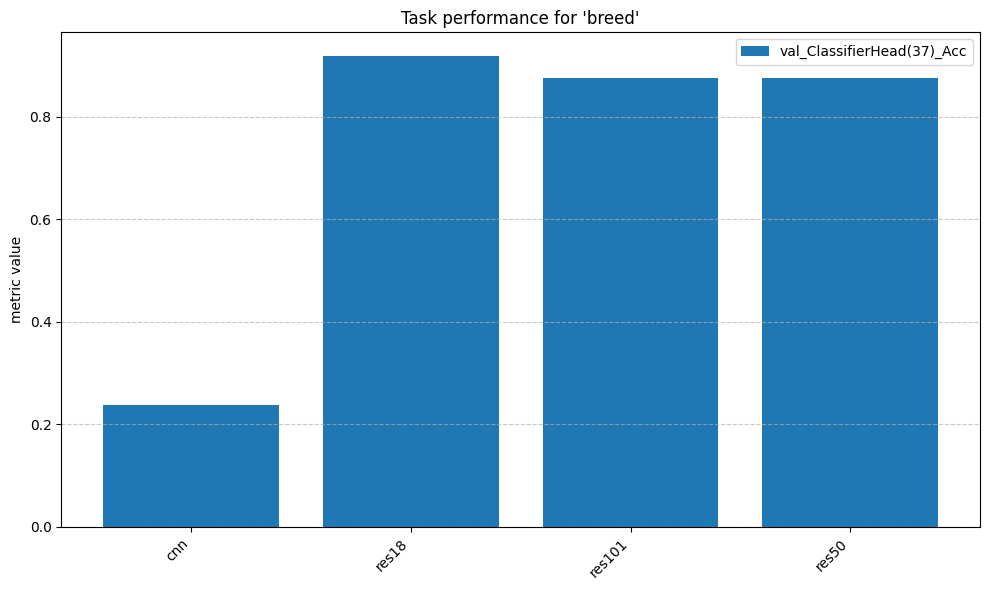

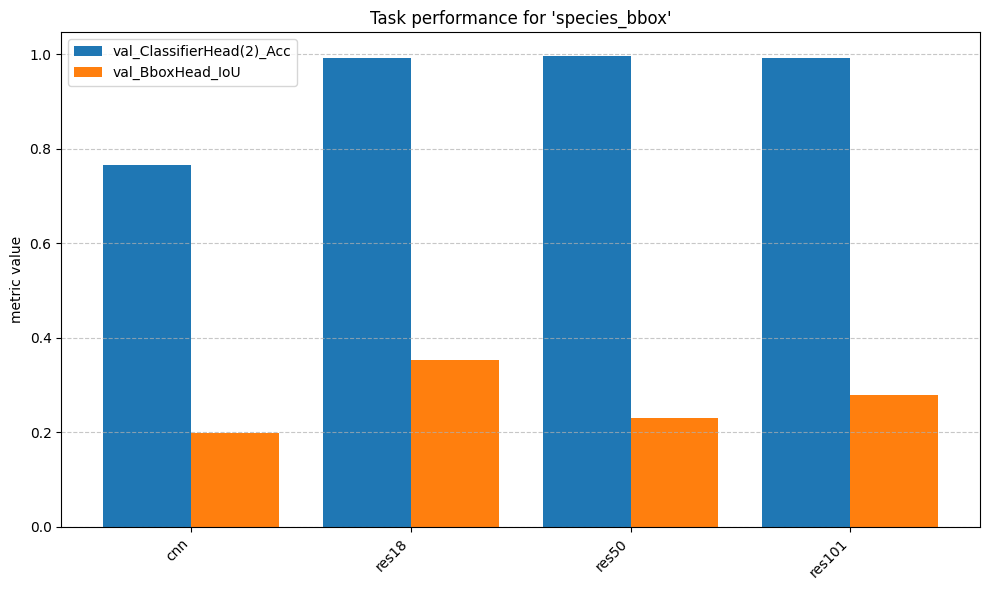

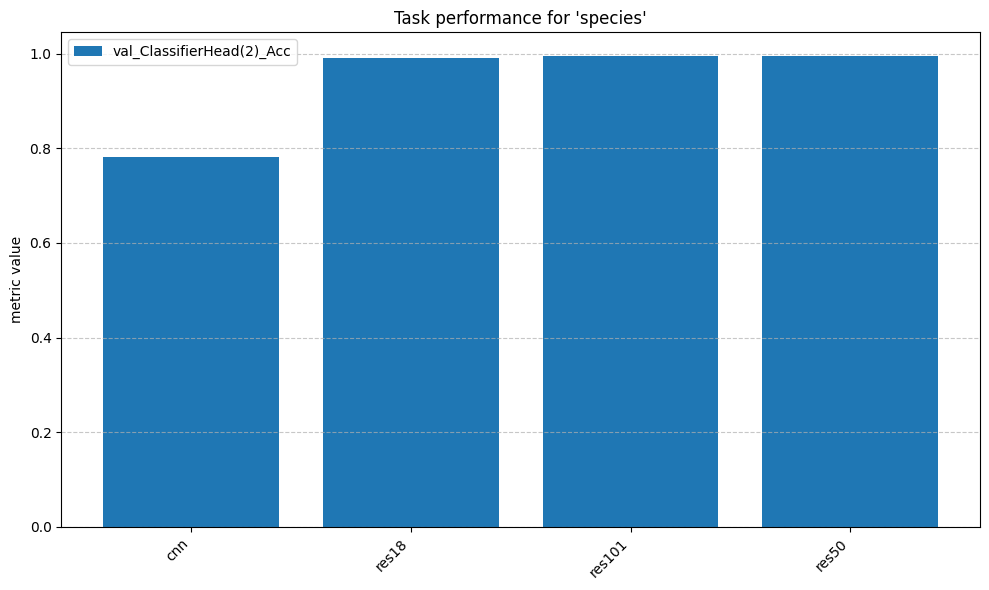

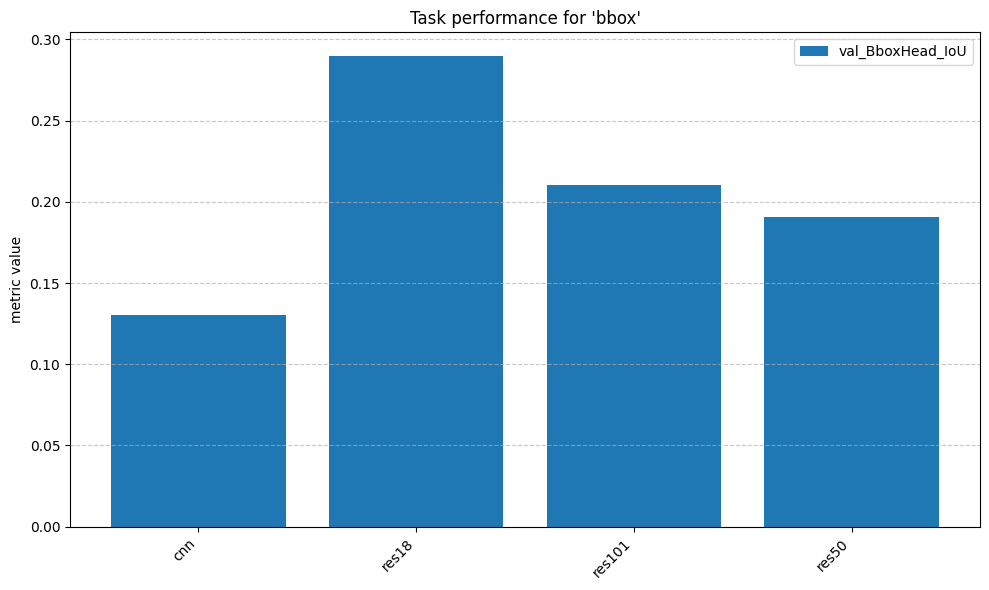

In [98]:
print("Printing best-epoch-performance per run per task:")
best_of = best_epochs_by_metric(df, "val_loss")
metrics = [key for key in best_of.keys() if "val" in key and "loss" not in key]
for task in best_of["task"].unique():
    relevant_metrics = [
        metric
        for metric in metrics
        if not any(best_of[best_of["task"] == task][metric].isnull())
    ]
    visualize_task_performance(best_of, task, eval_metrics=relevant_metrics)